In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from dataloader import prepare_dataloader
from utils import dataloader_one_batch, plot_tensors

In [36]:
tr, te = prepare_dataloader('./data', 'mnist', 1000, 1000, 2)
train_data, _ = dataloader_one_batch(tr)
test_data, _ = dataloader_one_batch(te)

In [144]:
X = train_data.view(-1, 1*28*28).T
q = 50
U, S, V = torch.pca_lowrank(X, q=q)

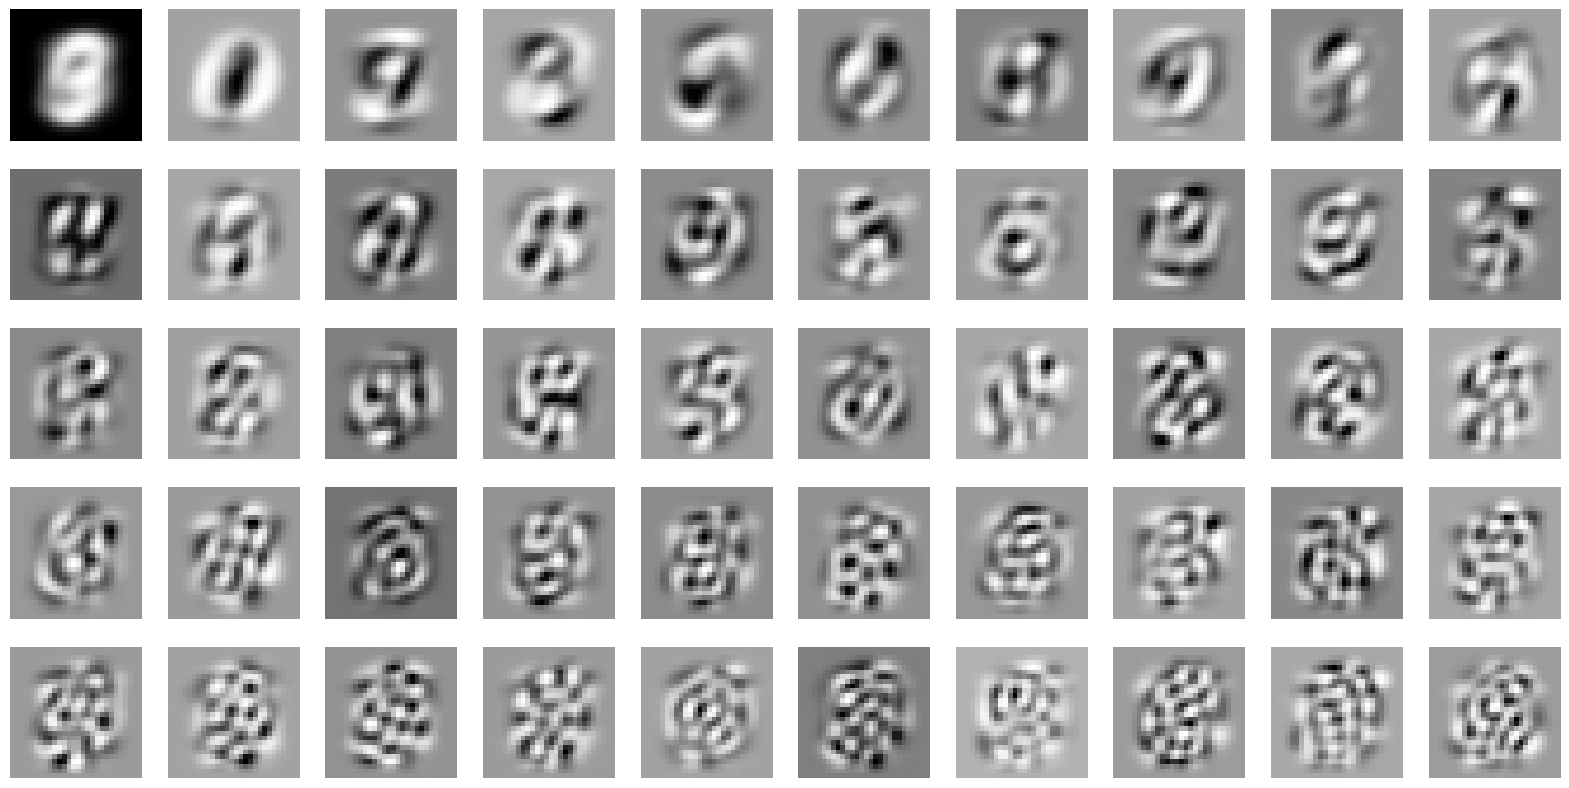

In [145]:
plot_tensors(U.view(1, 28, 28, q).permute(3, 0, 1, 2), 5, 10, 'grey')

In [157]:
coeff = torch.matmul(U.T, X).T
bases = U.view(1, 28, 28, q).permute(3, 0, 1, 2)
print(coeff[0].shape, bases.shape)

torch.Size([50]) torch.Size([50, 1, 28, 28])


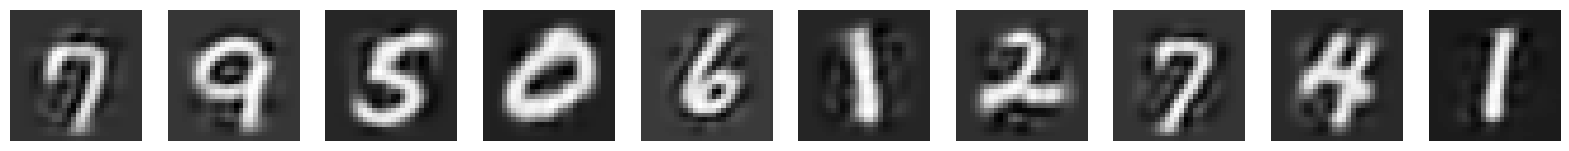

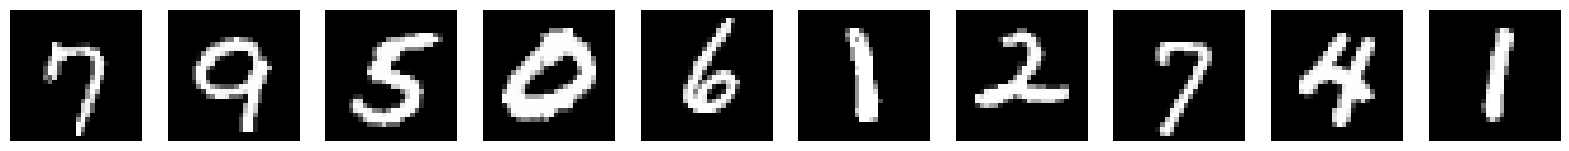

In [158]:
rec = torch.sum(coeff[:10].view(10, q, 1, 1, 1)*bases, dim=1)
plot_tensors(rec, 1, 10, 'grey')
plot_tensors(train_data[:10], 1, 10, 'grey')

In [4]:
import torch
t = 3
t * torch.ones((4, ), device='cpu', dtype=torch.long)

tensor([3, 3, 3, 3])

  0%|          | 0/999 [00:00<?, ?it/s]

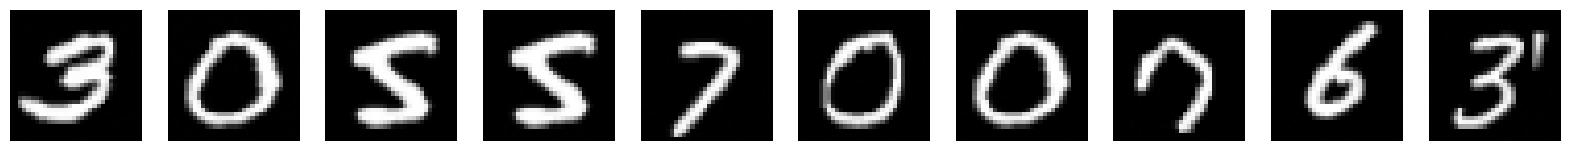

In [8]:
from tqdm.autonotebook import tqdm, trange

def score_nonparametric(z, t, X_hat):
    B, C, img_size, _ = z.shape
    K = X_hat.shape[0]
    t_expanded = t.view(B, 1, 1, 1, 1).expand(B, K, C, img_size, img_size)
    X_hat_expanded = X_hat.unsqueeze(dim=0)
    z_expanded = z.unsqueeze(dim=1)
    nom = -((z_expanded - X_hat_expanded * t_expanded)**2).sum(dim=[i for i in range(2, z.dim()+1)])
    den = (2 * (1 - t**2)).view(-1, 1)
    w_ = nom / den
    w = torch.softmax(w_, dim=1).view(B, K, 1, 1, 1)
    weighted_sum = torch.sum(X_hat_expanded * w, dim=1)
    return (weighted_sum * t.view(-1, 1, 1, 1) - z) / (1 - t**2).view(-1, 1, 1, 1)

num_samples = 10
img_size = 32
timesteps = 1000
betas = np.linspace(0.000001, 0.002, timesteps)
alphas = 1. - betas
alphas_cumprod = np.cumprod(alphas, axis=0)
ts = sqrt_alphas_cumprod = np.sqrt(alphas_cumprod)
z = torch.randn(num_samples, 1, img_size, img_size)
X_hat = train_data[:50]
for t in trange(len(betas)-1, 0, -1, leave=False):
    beta = betas[t]
    s = torch.zeros_like(z)
    # for j in range(len(Xs)):
    #     # XX = Xs[j] + 0.05*torch.randn_like(Xs[j])
    #     s += DDPM_CF_score(z, ts[t], Xs[j])
    # s /= len(Xs)
    s = score_nonparametric(z, torch.tensor(ts[t]).expand(num_samples,), X_hat)
    z = (z + beta * s) / alphas[t] + np.sqrt(beta) * torch.randn_like(z)
plot_tensors(z, 1, num_samples, 'grey')

In [38]:
import os
from utils import load_config
from model.unet import UNet
from model.diffusion import Diffusion

config_path = os.path.join('config', 'ddpm.yaml')
config = load_config(config_path)
unet = UNet(**config['unet_config'])
diffusion = Diffusion(config['diffusion_config'])

state = torch.load('ckpts/model_150000.pt', map_location='cpu')
unet.load_state_dict(state['unet'])

<All keys matched successfully>

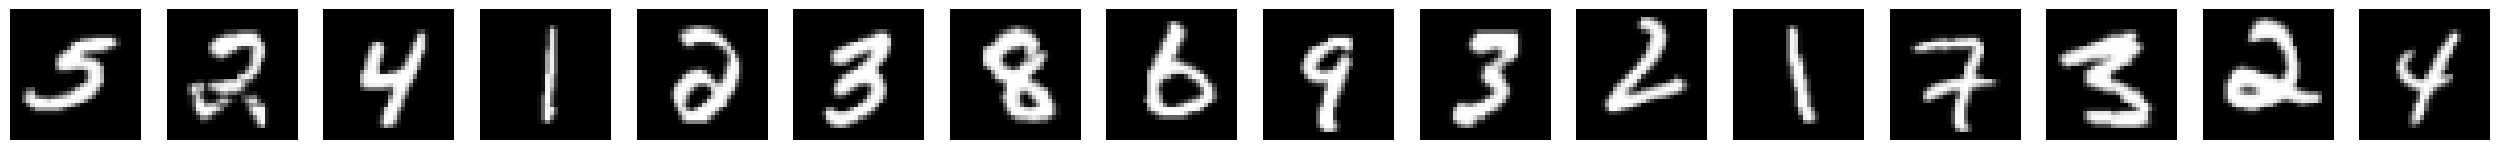

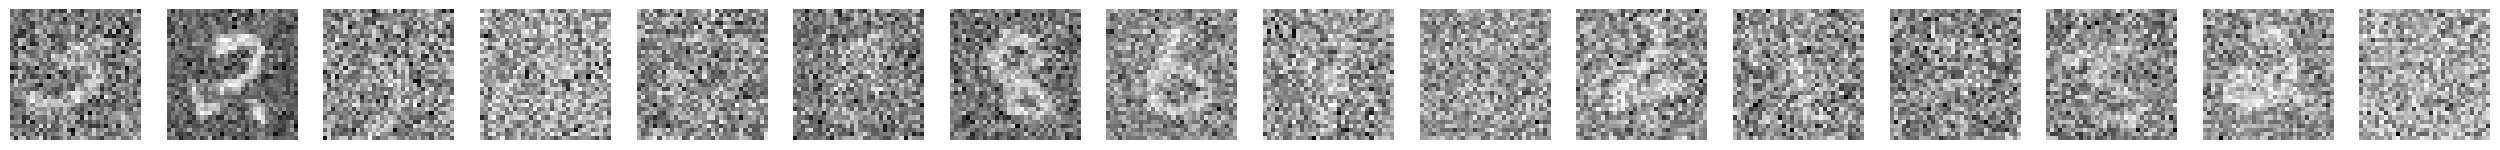

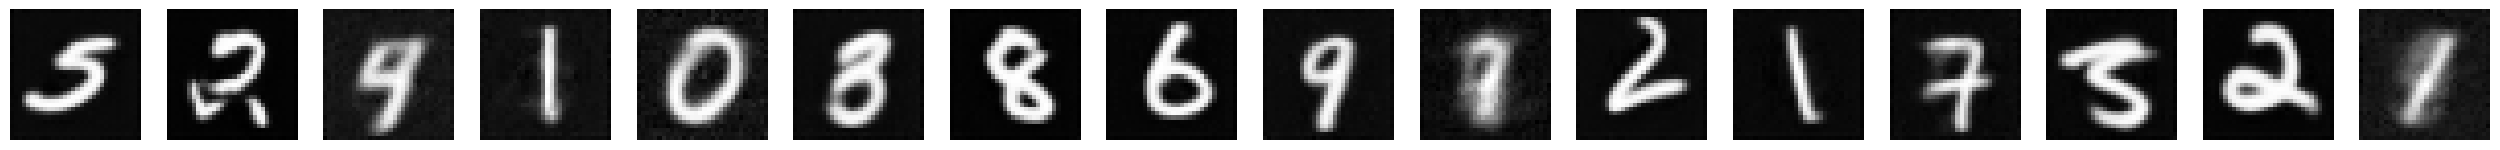

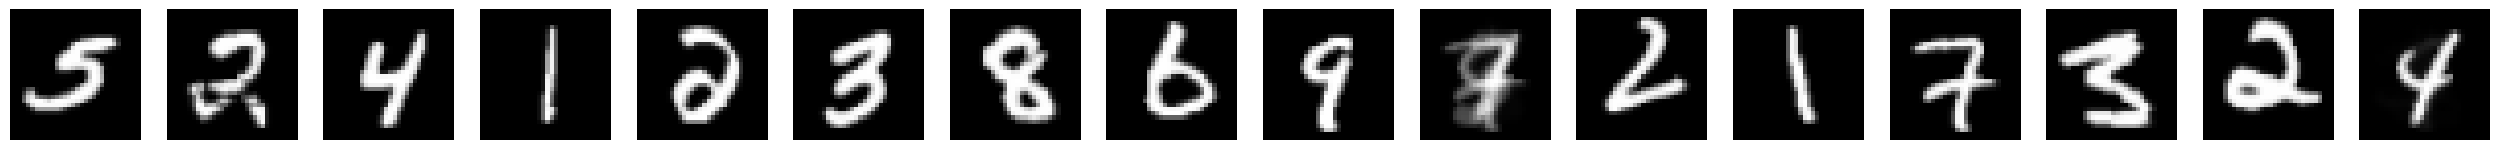

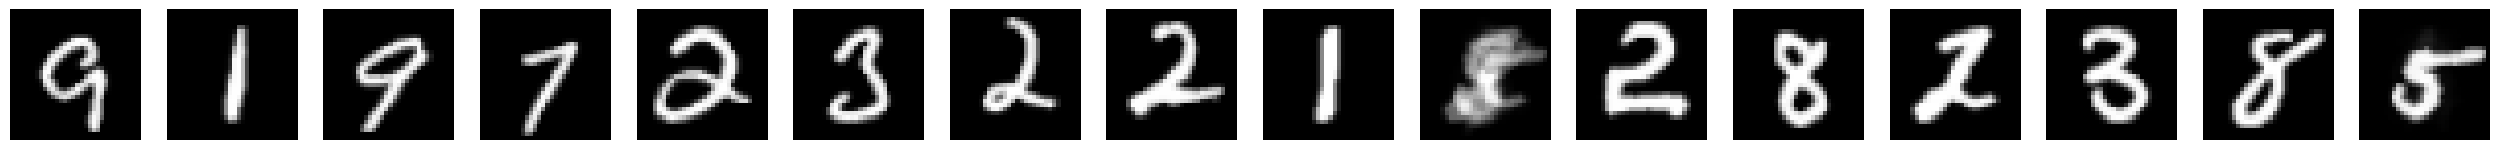

In [198]:
b = 16
x = test_data[20:(20+b)]
noise = torch.randn_like(x)
t = torch.randint(0, 700, (b,), dtype=torch.long)
x_t = diffusion.q_sample(x_0=x, t=t, noise=noise)
plot_tensors(x, 1, b, 'grey')
plot_tensors(x_t, 1, b, 'grey')
with torch.no_grad():
    score_p = unet(x_t, t)
    noise_p = score_p / -diffusion.extract_coef_at_t(diffusion.sqrt_recip_alphas_cumprod, t, x_t.shape)
    x_p = (x_t - noise_p * diffusion.extract_coef_at_t(diffusion.sqrt_one_minus_alphas_cumprod, t, x_t.shape)) / diffusion.extract_coef_at_t(diffusion.sqrt_alphas_cumprod, t, x_t.shape)
    plot_tensors(x_p, 1, b, 'grey')

    # Note: This is problematic, fix this.
    # score_np = score_nonparametric(x_t, t, test_data[:50])
    # noise_np = score_np / -diffusion.extract_coef_at_t(diffusion.sqrt_recip_alphas_cumprod, t, x_t.shape)
    # x_np = (x_t - noise_np * diffusion.extract_coef_at_t(diffusion.sqrt_one_minus_alphas_cumprod, t, x_t.shape)) / diffusion.extract_coef_at_t(diffusion.sqrt_alphas_cumprod, t, x_t.shape)
    X_hat = test_data[20:(20+b)]
    B, C, img_size, _ = x_t.shape
    K = X_hat.shape[0]
    tau = diffusion.extract_coef_at_t(diffusion.sqrt_alphas_cumprod, t, x_t.shape)
    t_expanded = tau.view(B, 1, 1, 1, 1).expand(B, K, C, img_size, img_size)
    X_hat_expanded = X_hat.unsqueeze(dim=0)
    z_expanded = x_t.unsqueeze(dim=1)
    nom = -((z_expanded - X_hat_expanded * t_expanded)**2).sum(dim=[i for i in range(2, z.dim()+1)])
    den = (2 * (1 - tau**2)).view(-1, 1)
    w_ = nom / den
    w = torch.softmax(w_, dim=1).view(B, K, 1, 1, 1)
    weighted_sum = torch.sum(X_hat_expanded * w, dim=1)

    plot_tensors(weighted_sum, 1, b, 'grey')

    X_hat = test_data[120:(120+b)]
    B, C, img_size, _ = x_t.shape
    K = X_hat.shape[0]
    tau = diffusion.extract_coef_at_t(diffusion.sqrt_alphas_cumprod, t, x_t.shape)
    t_expanded = tau.view(B, 1, 1, 1, 1).expand(B, K, C, img_size, img_size)
    X_hat_expanded = X_hat.unsqueeze(dim=0)
    z_expanded = x_t.unsqueeze(dim=1)
    nom = -((z_expanded - X_hat_expanded * t_expanded)**2).sum(dim=[i for i in range(2, z.dim()+1)])
    den = (2 * (1 - tau**2)).view(-1, 1)
    w__real = nom / den
    w_real = torch.softmax(w__real, dim=1).view(B, K, 1, 1, 1)
    weighted_sum = torch.sum(X_hat_expanded * w, dim=1)

    plot_tensors(weighted_sum, 1, b, 'grey')


In [210]:
import time
start_time = time.time()
for i in range(100):
    x = unet(x_t, t)
duration = time.time() - start_time
print(duration / 100)


0.5855374717712403


(-1.19, 16.19, 0.0, 0.9503350228071212)

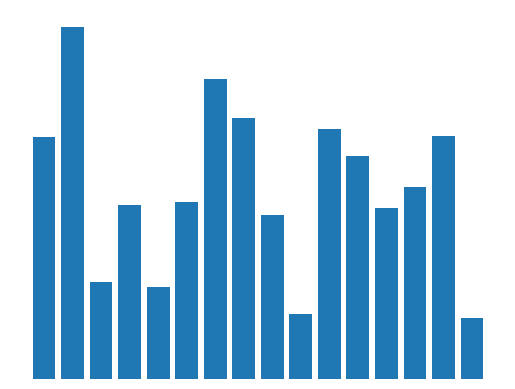

In [204]:
plt.bar(np.arange(b), tau.squeeze())
plt.axis('off')


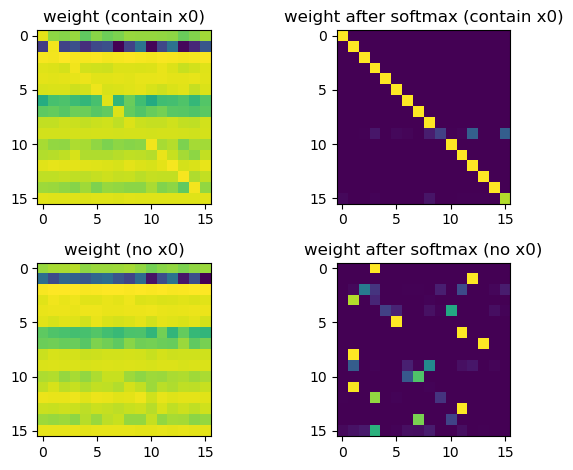

In [200]:
# plt.bar(torch.arange(len(w)), w)
plt.subplot(221)
plt.imshow(w_)
plt.title('weight (contain x0)')
plt.subplot(222)
plt.imshow(w.squeeze())
plt.title('weight after softmax (contain x0)')
plt.subplot(223)
plt.imshow(w__real)
plt.title('weight (no x0)')
plt.subplot(224)
plt.imshow(w_real.squeeze())
plt.title('weight after softmax (no x0)')
plt.tight_layout()